In [ ]:
!pip install transformers[sentencepiece] spacy rouge

In [ ]:
!nvidia-smi

In [ ]:
!python -m spacy download en_core_web_lg

In [5]:
import torch
import re
import spacy
import nltk
import json
import en_core_web_lg
import pandas as pd
from tqdm import tqdm
from rouge import Rouge 
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from transformers import AutoModelForMaskedLM, AutoModel, AutoTokenizer, pipeline

In [ ]:
nlp = en_core_web_lg.load()
nltk.download('punkt')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/My Drive/

In [ ]:
!ls

In [15]:
cd /content/drive/My Drive/Dataset/

/content/drive/My Drive/Dataset


In [ ]:
!gdown https://drive.google.com/uc?id=1wBD5codLeDD8iEBIe_pnTHqQr4hqLsqi

In [ ]:
!gdown https://drive.google.com/uc?id=1mj79A-lAVYIWXtvDKUTslyIjPvyHi2MJ

In [19]:
f = open ('/content/drive/MyDrive/Dataset/qa_multi_answer.json', "r")
qa = json.loads(f.read())

In [ ]:
qa['data'][0]

In [21]:
cd /content/drive/My Drive/base_bert/final_base_bert_QA_checkpoint

/content/drive/My Drive/base_bert/final_base_bert_QA_checkpoint


In [22]:
!ls

config.json		 pytorch_model.bin	  training_args.bin
nbest_predictions_.json  special_tokens_map.json  vocab.txt
predictions_.json	 tokenizer_config.json


In [63]:
n_top = 3
rouge = Rouge()
smoothie = SmoothingFunction().method4
bleu_scores = []
rouge1_scores = []
rouge2_scores = []
rougel_scores = []


model_names = {'/content/drive/My Drive/2_squeeze/Final_squeeze-squad':'question_answering',
               '/content/drive/My Drive/2_squeeze/Squeeze-bert_MLM/MLM_output_dir/Final_squeeze_MLM':'question_answering',
               '/content/drive/My Drive/Squeeze/QA_Squeeze_Squad/squeeze-bert-squad-QA':'question_answering',
               '/content/drive/My Drive/base_bert/final_base_bert_QA_checkpoint':'question_answering',
               '/content/drive/My Drive/base_bert/MLM_base_bert':'question_answering',
               '/content/drive/My Drive/base_bert/QA_base_bert/base_bert_QA_Final':'question_answering'
               }

In [50]:
cd /content/drive/My Drive/Squeeze/QA_Squeeze_Squad/squeeze-bert-squad-QA

/content/drive/My Drive/Squeeze/QA_Squeeze_Squad/squeeze-bert-squad-QA


In [51]:
cd /content/drive/My Drive/base_bert/QA_base_bert

/content/drive/My Drive/base_bert/QA_base_bert


In [52]:
!ls


base_bert_QA_Final  base_bert_QA_final.zip


In [53]:
class SentenceSimilarity():
    def __init__(self, model_name=None, device='cuda'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).eval()

    def __call__(self, text):
        tokens = self.tokenizer(text, padding=True, return_tensors='pt', truncation=True)
        with torch.no_grad():
            embeddings = self.model(**tokens).last_hidden_state

        mask = tokens['attention_mask'].unsqueeze(-1).expand(embeddings.shape).float()
        sentence_embeddings = torch.sum(embeddings * mask, dim=1) / torch.clamp(mask.sum(1), min=1e-9) 
        return sentence_embeddings

    def compute_label_embedding(self, labels):
        self.label_embeds = self(labels)
    
    def similarity(self, example):
        return torch.cosine_similarity(self(example), self.label_embeds).tolist()

In [54]:
def get_answer(sentences, question, model, model_type, n_top=None):
  if model_type == 'similarity':
    scores = model.similarity(question)
    dic = {}

    for i, ex in enumerate(sentences):
        dic[ex] = scores[i]

    s = pd.Series(dic, name='Similarity')
    s.index.name = 'Sentences'
    df = s.reset_index()
    df.sort_values(by='Similarity', ascending=False, inplace=True)
    answer = " ".join(df.iloc[:n_top]['Sentences'])

  elif model_type == 'question_answering':
    context = " ".join(sentences)
    answer = model(question=question, context=context)['answer']

  return answer

In [55]:
def get_score(token_reference, token_candidate, sf):
  bleu_score = sentence_bleu(token_reference, token_candidate, smoothing_function=sf, weights=(1, 0, 0, 0))
  rouge_score = rouge.get_scores(candidate, reference)
  return bleu_score, rouge_score[0]['rouge-1']['f'], rouge_score[0]['rouge-2']['f'], rouge_score[0]['rouge-l']['f']

In [56]:
def load_model(model_name, model_type):
  if model_type == 'similarity':
    model = SentenceSimilarity(model_name)

  elif model_type == 'question_answering':
    model = pipeline(model=model_name, tokenizer=model_name, task="question-answering")
    
  return model

In [57]:
df = pd.DataFrame(columns=['Type', 'BLEU', 'ROUGE_1', 'ROUGE_2', 'ROUGE_l'], index=list(model_names.keys()))
df

,Type,BLEU,ROUGE_1,ROUGE_2,ROUGE_l
/content/drive/My Drive/2_squeeze/Final_squeeze-squad,NaN,NaN,NaN,NaN,NaN
/content/drive/My Drive/2_squeeze/Squeeze-bert_MLM/MLM_output_dir/Final_squeeze_MLM,NaN,NaN,NaN,NaN,NaN
/content/drive/My Drive/Squeeze/QA_Squeeze_Squad/squeeze-bert-squad-QA,NaN,NaN,NaN,NaN,NaN
/content/drive/My Drive/base_bert/final_base_bert_QA_checkpoint,NaN,NaN,NaN,NaN,NaN
/content/drive/My Drive/base_bert/MLM_base_bert,NaN,NaN,NaN,NaN,NaN
/content/drive/My Drive/base_bert/QA_base_bert,NaN,NaN,NaN,NaN,NaN


In [ ]:
# import numpy as np

# for data in qa['data']:
#   context = data['context']
#   doc = nlp(context)
#   print("*************")
#   print(context)
#   print("*************")
#   sentences = [str(sentence) for sentence in list(doc.sents)]

#   if model_type == 'similarity':
#     model.compute_label_embedding(sentences)
  
#   for q_a in data['qas']:
#     question = q_a['question']
#     reference = "".join(q_a['answers'])

#     # if type(question) == list:
#     #   question = q_a['question'][0]
#     print("##################")
#     print(question)

#   break

In [85]:
for model_name in tqdm(model_names):
  model_type = model_names[model_name]
  df['Type'][model_name] = model_type

  model = load_model(model_name, model_type)

  for data in qa['data']:
    context = data['context']
    doc = nlp(context)
    sentences = [str(sentence) for sentence in list(doc.sents)]

    if model_type == 'similarity':
      model.compute_label_embedding(sentences)
    
    for q_a in data['qas']:
      question = q_a['question']
      if type(question) == list:
        question = q_a['question'][0]


      reference = "".join(q_a['answers'])

      candidate = get_answer(sentences, question, model, model_type, n_top)
      token_reference = nltk.word_tokenize(reference)
      token_candidate = nltk.word_tokenize(candidate)

      try :
        bleu_score, rouge1_score, rouge2_score, rougel_score = get_score(
            token_reference, token_candidate, smoothie)


        bleu_scores.append(bleu_score)
        rouge1_scores.append(rouge1_score)
        rouge2_scores.append(rouge2_score)
        rougel_scores.append(rougel_score)
      except:
        pass
      

  df['BLEU'][model_name] = sum(bleu_scores)/len(bleu_scores)
  df['ROUGE_1'][model_name] = sum(rouge1_scores)/len(rouge1_scores)
  df['ROUGE_2'][model_name] = sum(rouge2_scores)/len(rouge2_scores)
  df['ROUGE_l'][model_name] = sum(rougel_scores)/len(rougel_scores)

 17%|█▋        | 1/6 [06:42<33:34, 402.89s/it]Some weights of the model checkpoint at /content/drive/My Drive/2_squeeze/Squeeze-bert_MLM/MLM_output_dir/Final_squeeze_MLM were not used when initializing SqueezeBertForQuestionAnswering: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing SqueezeBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SqueezeBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some 

In [103]:
sum(bleu_scores)/len(bleu_scores)

0.05994253804045497

In [61]:
cd /content/drive/My Drive/base_bert/QA_base_bert

/content/drive/My Drive/base_bert/QA_base_bert


In [62]:
!ls

base_bert_QA_Final  base_bert_QA_final.zip


In [86]:
print(token_reference)

['Metformin', 'should', 'not', 'be', 'given', 'to', 'a', 'child', 'younger', 'than', '10', 'years', 'old.Some', 'forms', 'of', 'metformin', 'are', 'not', 'approved', 'for', 'use', 'by', 'anyone', 'younger', 'than', '18', 'years', 'old', '.']


In [87]:
token_candidate

['10']

In [109]:
df.columns

Index(['Unnamed: 0', 'Type', 'BLEU', 'ROUGE_1', 'ROUGE_2', 'ROUGE_l'], dtype='object')

In [115]:
df['Unnamed: 0'][0],df['BLEU'][0],  df['ROUGE_1'][0], df['ROUGE_2'][0], df['ROUGE_l'][0]

('/content/drive/My Drive/2_squeeze/Final_squeeze-squad',
 0.045835349004110466,
 0.19854756525977146,
 0.14850040140960274,
 0.19770246399303446)

In [116]:
df['Unnamed: 0'][1],df['BLEU'][1],  df['ROUGE_1'][1], df['ROUGE_2'][1], df['ROUGE_l'][1]

('/content/drive/My Drive/2_squeeze/Squeeze-bert_MLM/MLM_output_dir/Final_squeeze_MLM',
 0.047861168051024916,
 0.17696092711645833,
 0.12715152845920613,
 0.17566550960893856)

In [117]:
df['Unnamed: 0'][2],df['BLEU'][2],  df['ROUGE_1'][2], df['ROUGE_2'][2], df['ROUGE_l'][2]

('/content/drive/My Drive/Squeeze/QA_Squeeze_Squad/squeeze-bert-squad-QA',
 0.04644906514503649,
 0.18316448434589336,
 0.133588030588075,
 0.18208277306962864)

In [118]:
df['Unnamed: 0'][3],df['BLEU'][3],  df['ROUGE_1'][3], df['ROUGE_2'][3], df['ROUGE_l'][3]

('/content/drive/My Drive/base_bert/final_base_bert_QA_checkpoint',
 0.051796216153443916,
 0.2225680806645339,
 0.17216889426750046,
 0.22153564830299854)

In [119]:
df['Unnamed: 0'][4],df['BLEU'][4],  df['ROUGE_1'][4], df['ROUGE_2'][4], df['ROUGE_l'][4]

('/content/drive/My Drive/base_bert/MLM_base_bert',
 0.0623308143722647,
 0.20567073421978976,
 0.15514268988697952,
 0.204525759253429)

```
 Model name:  Final_squeeze-squad
 Bleu Scores:  0.04644906514503649,
 Rouge_1 Scores average0.18316448434589336,
 Rouge_1 Scores average 0.133588030588075,
 Rouge_2 Scores average 0.18208277306962864 
```
--- 
```
 Model name:   Final_squeeze_MLM
 Bleu Scores:  0.047861168051024916,
 Rouge_1 Scores average 0.17696092711645833,
 Rouge_2 Scores average 0.12715152845920613,
 Rouge_l Scores average 0.17566550960893856
  
```
---  
```
 Model name:  squeeze-bert-squad-QA
 Bleu Scores:  0.04644906514503649,
 Rouge_1 Scores average 0.18316448434589336,
 Rouge_2 Scores average  0.133588030588075,
 Rouge_l Scores average 0.18208277306962864
```
---
``` 
 Model name:  final_base_bert_QA_checkpoint
 Bleu Scores:  0.051796216153443916,
 Rouge_1 Scores average  0.2225680806645339,
 Rouge_2 Scores average  0.17216889426750046,
 Rouge_l Scores average  0.22153564830299854
```
---
``` 
 Model name:  MLM_base_bert
 Bleu Scores:  0.0623308143722647,
 Rouge_1 Scores average  0.20567073421978976,
 Rouge_2 Scores average  0.15514268988697952,
 Rouge_l Scores average  0.204525759253429
```
---


In [88]:
df

,Type,BLEU,ROUGE_1,ROUGE_2,ROUGE_l
/content/drive/My Drive/2_squeeze/Final_squeeze-squad,question_answering,0.0458353,0.198548,0.1485,0.197702
/content/drive/My Drive/2_squeeze/Squeeze-bert_MLM/MLM_output_dir/Final_squeeze_MLM,question_answering,0.0478612,0.176961,0.127152,0.175666
/content/drive/My Drive/Squeeze/QA_Squeeze_Squad/squeeze-bert-squad-QA,question_answering,0.0464491,0.183164,0.133588,0.182083
/content/drive/My Drive/base_bert/final_base_bert_QA_checkpoint,question_answering,0.0517962,0.222568,0.172169,0.221536
/content/drive/My Drive/base_bert/MLM_base_bert,question_answering,0.0623308,0.205671,0.155143,0.204526
/content/drive/My Drive/base_bert/QA_base_bert,question_answering,NaN,NaN,NaN,NaN


In [89]:
df.to_csv('qa_finetune_model.csv')

In [90]:
df = pd.read_csv('qa_finetune_model.csv')

In [91]:
df

,Unnamed: 0,Type,BLEU,ROUGE_1,ROUGE_2,ROUGE_l
0,/content/drive/My Drive/2_squeeze/Final_squeez...,question_answering,0.045835,0.198548,0.148500,0.197702
1,/content/drive/My Drive/2_squeeze/Squeeze-bert...,question_answering,0.047861,0.176961,0.127152,0.175666
2,/content/drive/My Drive/Squeeze/QA_Squeeze_Squ...,question_answering,0.046449,0.183164,0.133588,0.182083
3,/content/drive/My Drive/base_bert/final_base_b...,question_answering,0.051796,0.222568,0.172169,0.221536
4,/content/drive/My Drive/base_bert/MLM_base_bert,question_answering,0.062331,0.205671,0.155143,0.204526
5,/content/drive/My Drive/base_bert/QA_base_bert,question_answering,NaN,NaN,NaN,NaN


In [98]:
# list(df.iloc[7:]['Unnamed: 0'])

['/content/drive/My Drive/base_bert/final_base_bert_QA_checkpoint',
 '/content/drive/My Drive/base_bert/MLM_base_bert',
 '/content/drive/My Drive/base_bert/QA_base_bert']

In [93]:
# index = list(df.iloc[7:]['Unnamed: 0'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f600e1ee250>,
      dtype=object)

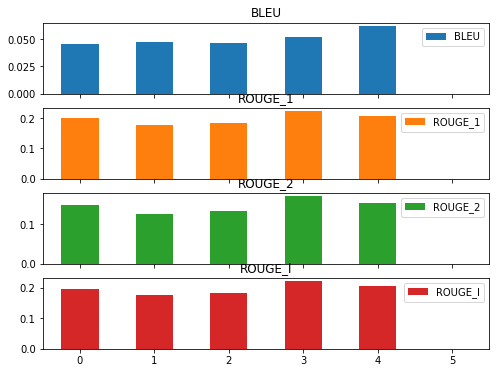

In [94]:
df.iloc[:6].plot.bar(rot=0, subplots=True, figsize=(8, 6))

In [99]:
# df.iloc[7:].plot.bar(rot=0, subplots=True, figsize=(16, 8))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f600dcc2310>,
      dtype=object)

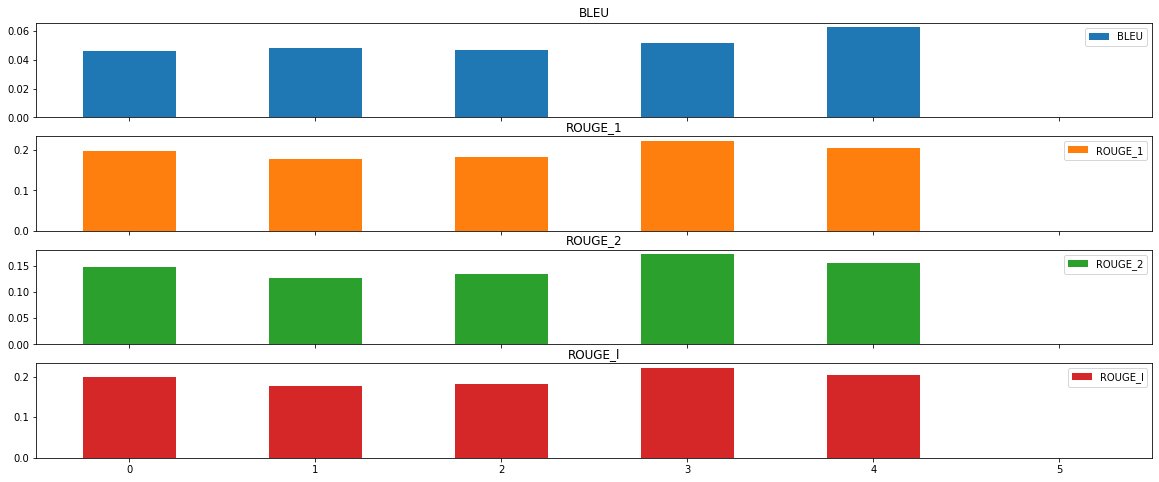

In [96]:
df.plot.bar(rot=0, subplots=True, figsize=(20, 8))